In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
data = np.loadtxt(open("mnist_train_small.csv", "rb"), delimiter=",")

labels = data[:, 0]
data = data[:, 1:]

data_norm = data / np.max(data)

data_norm = data_norm.reshape(data_norm.shape[0], 1, 28, 28)

In [3]:
data_tensor = torch.FloatTensor(data_norm)
labels_tensor = torch.LongTensor(labels)

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2, random_state=17)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [4]:
for i in range(train_loader.dataset.tensors[0].shape[0]):
    image = train_loader.dataset.tensors[0][i, :, :]
    
    random_roll = np.random.randint(-10, 11)
    image = torch.roll(image, random_roll, dims=1)
    
    train_loader.dataset.tensors[0][i, :, :] = image

In [5]:
for i in range(test_loader.dataset.tensors[0].shape[0]):
    image = test_loader.dataset.tensors[0][i, :, :]

    random_roll = np.random.randint(-10, 11)
    image = torch.roll(image, random_roll, dims=1)

    test_loader.dataset.tensors[0][i, :, :] = image

In [6]:
def model(print_toggle=False):
    
    class CNN(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()
            
            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            
            expect_size = np.floor((5 + 2 * 0 - 1) / 1) + 1
            expect_size = 20*int(expect_size**2)
            
            self.fc1 = nn.Linear(expect_size, 50)
            
            self.out = nn.Linear(50, 10)
            
            self.print = print_toggle
        
        def forward(self, x):
            print(f"Input: {x.shape}") if self.print else None
            
            x = self.conv1(x)
            x = f.max_pool2d(x, 2)
            x = f.relu(x)
            print(f"Layer conv1/pool1: {x.shape}") if self.print else None
            
            x = self.conv2(x)
            x = f.max_pool2d(x, 2)
            x = f.relu(x)
            print(f"Layer conv2/pool2: {x.shape}") if self.print else None
            
            num_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(num_units))
            if self.print: print(f"Vectorize: {x.shape}")
            
            x = self.fc1(x)
            x = f.relu(x)
            if self.print: print(f"Layer fc1: {x.shape}")
            
            x = self.out(x)
            if self.print: print(f"Layer fc2: {x.shape}")
            
            return x
        
    
    cnn = CNN(print_toggle)
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
    
    return cnn, loss_fun, optimizer

In [7]:
cnn = model(True)[0]
summary(cnn, (1, 28, 28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Layer conv2/pool2: torch.Size([2, 20, 5, 5])
Vectorize: torch.Size([2, 500])
Layer fc1: torch.Size([2, 50])
Layer fc2: torch.Size([2, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─Conv2d: 1-2                            [-1, 20, 11, 11]          5,020
├─Linear: 1-3                            [-1, 50]                  25,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
Total mult-adds (M): 0.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─Conv2d: 1-2                            [-1, 20, 11, 11]          5,020
├─Linear: 1-3                            [-1, 50]                  25,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
Total mult-adds (M): 0.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19

In [8]:
def train_model():
    
    num_epochs = 30

    cnn, loss_fun, optimizer = model()
    
    losses = []
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        
        cnn.train()
        
        batch_acc = []
        batch_loss = []
        
        for x, y in train_loader:
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1)==y).float()))
        
        train_acc.append(np.mean(batch_acc))
        
        losses.append(np.mean(batch_loss))
        
        cnn.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(cnn(x), axis=1)==y).float()))
        
    return train_acc, test_acc, losses

In [9]:
train_acc, test_acc, losses = train_model()

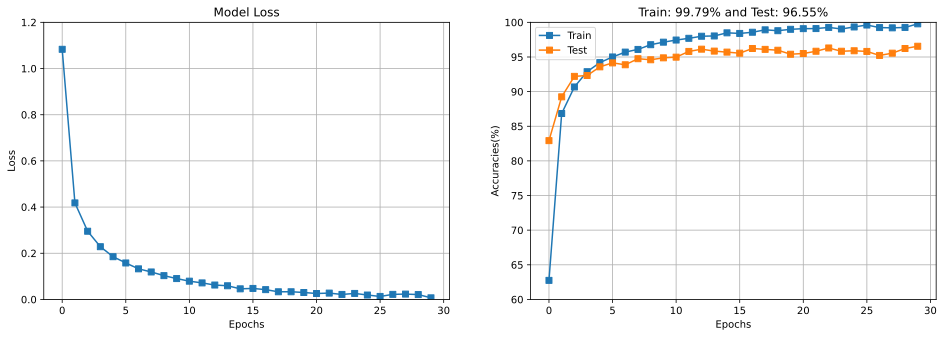

In [13]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(losses, "s-")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_ylim([0, 1.2])
axis[0].set_title("Model Loss")
axis[0].grid()

axis[1].plot(train_acc, "s-", label="Train")
axis[1].plot(test_acc, "s-", label="Test")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracies(%)")
axis[1].set_ylim([60, 100])
axis[1].set_title(f"Train: {train_acc[-1]:0.2f}% and Test: {test_acc[-1]:0.2f}%")
axis[1].grid()

plt.legend();